In [92]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from helper import generate_regression, fit_different_models, plot_coefficients, plot_overfitting, plot_coefs, cross_validate_regularization, cross_validate_feature_range, regularization_coef_progression, features_selected, cross_validate_lambda_en, plot_pca_cumvar, compare_coefficients_mult_methods, regularization_analysis
import pyreadr
from helper import plot_regularization_path

import warnings
warnings.filterwarnings('ignore')


# Notes

- not sure if the synthetitc dataset is useful for visualizing pca for feature selection, maybe we should reduce the features to 20 (10 signal 10 noise)
- TODO: Continue PCA feature extraction
- TODO: Does it make sense to do PCA after the first part? We can also do it at the end, or we leave it and add more in-depth analysis of Principle components (let's see what they are made out of -> but then probably a dataset with more interpretability would work better)
- Add something to Lasso and Ridge Cross Validation functions from SKLearn -> better explanations
- I think we probably can add Stepwise regression and hierarhcical clustering of feature correlations no? This notebook is not too loaded
- Maybe different dataset for PCR, could be smart
- Maybe plots chli apasse für pcr (cross validation plots)

TODO adjustments:
- Maybre remove the first part and directly go to overfitting to noise
- The train/test error plot for overfitting does not look as nice with the example with only a few points and features, it may be better if we use the really high-dimensional for this because it visualizes it nicely (i think the reason is, that p is not that much greater than n)

<br><br>
# **Table of Contents**

- [Finding "Significant" Patterns in Noise](#finding-significant-patterns-in-noise)
- [Overfitting to Noise](#overfitting-to-noise)
- [Principal Component Analysis (PCA): Finding Structure in High Dimensions](#principal-component-analysis-pca-finding-structure-in-high-dimensions)
- [Regularization Methods](#regularization-methods)
  - [Ridge Regression: Penalizing Large Coefficients](#ridge-regression-penalizing-large-coefficients-again-we-should-use-a-different-dataset-but-let-that-be-a-problem-for-once-i-got-all-the-code-and-ideas)
  - [LASSO Regression: Zeroing Out Irrelevant Features](#lasso-regression-zeroing-out-irrelevant-features)
  - [Elastic Net: Combining Ridge and LASSO](#elastic-net-combining-ridge-and-lasso)
  - [Regularization Methods Overview](#regularization-methods-overview)

<br><br>
# **Hands-On: Feature Selection and Regularization**

## Learning Goals
By the end of this session, you will be able to:

- **Identify the multiple testing problem in high-dimensional data**
  - Recognize how random correlations appear statistically significant in datasets with more features than samples
  - Understand why traditional statistical approaches fail when p >> n

- **Detect and avoid overfitting to noise**
  - Demonstrate how models can find "patterns" in completely synthetic data with no true relationships
  - Apply proper validation techniques to distinguish real signals from false discoveries

- **Apply dimensionality reduction for high-dimensional analysis**
  - Use PCA to identify meaningful structure in datasets with many features
  - Interpret principal components and explained variance ratios in high-dimensional contexts

- **Implement regularization techniques for feature selection**
  - Apply Ridge regression to penalize large coefficients and improve generalization
  - Use LASSO regression for automatic feature selection by zeroing out irrelevant variables
  - Combine approaches with Elastic Net to balance Ridge and LASSO penalties

---
<br><br>
# **Overfitting to Noise**

We will demonstrate how Models can overfit to noise if we have a lot of features and not enough samples for the model to learn the actual relevant relationships. For this we use a new generated dataset that has 1 relevant feature that has a relationship with the target value and 14 features that are just random noise. 

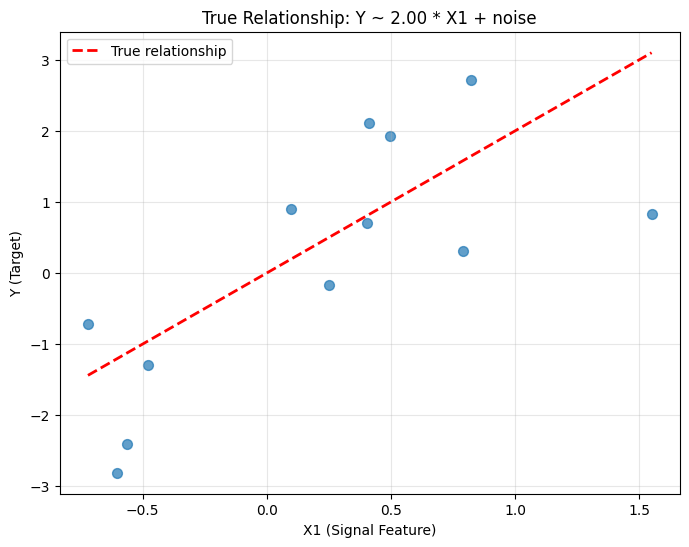

In [93]:
X, y, X_test, y_test, coef = generate_regression()

Now let's fit a simple linear regression using only X1 (the true signal feature):

**Model: Y ~ X1**

- Uses the correct feature that actually generates Y
- Should recover the true coefficient (≈ 2)
- Serves as our baseline for comparison

As we can see, the linear regression nicely recovers the true relationship. Now let's explore what happens when we include additional noise features.

**Models to compare:**
- **p=4**: Include 3 irrelevant features alongside X1
- **p=8**: Include 7 irrelevant features alongside X1  
- **p=15**: Include 14 irrelevant features alongside X1

Each model will fit: Y ~ X1 + X2 + ... + Xp

We'll plot the same X1 vs Y relationship to see how adding noise features affects predictions.

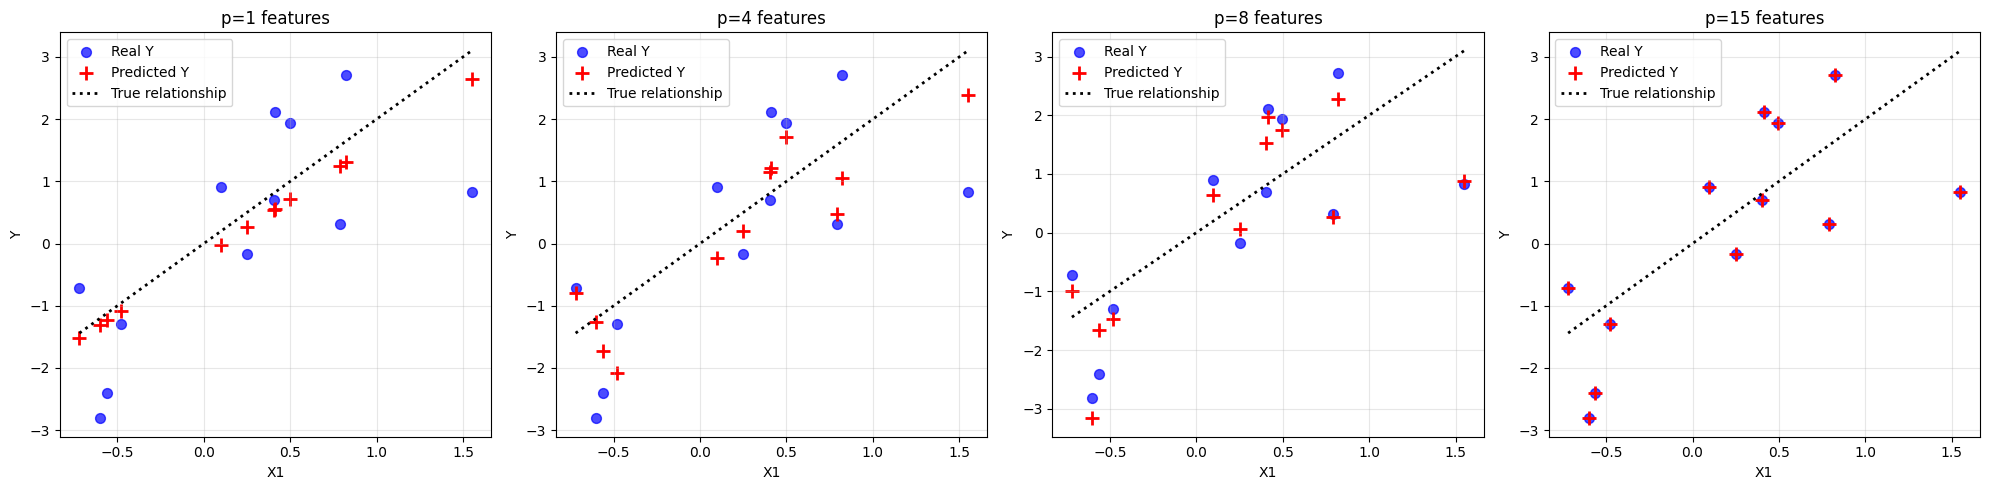

In [94]:
# Test different numbers of features
feature_counts = [1, 4, 8, 15]

fit_different_models(X, y, coef, feature_counts)

With increasing number of features, the fitted values start to deviate from the true model (dotted line) and move closer towards the observed data points. With p=15, the fitted values match the data perfectly—the model captures noise and overfits.

**Key observations:**
- **p=1**: Good fit to true relationship (baseline)
- **p=4**: Slight deviation from true relationship
- **p=8**: More pronounced overfitting to individual points  
- **p=15**: Perfect fit to training data (including noise)

Let's examine what happens to the estimated coefficients as we add more features. Since only X1 should have a non-zero coefficient (≈2), this reveals how noise features corrupt parameter estimates.

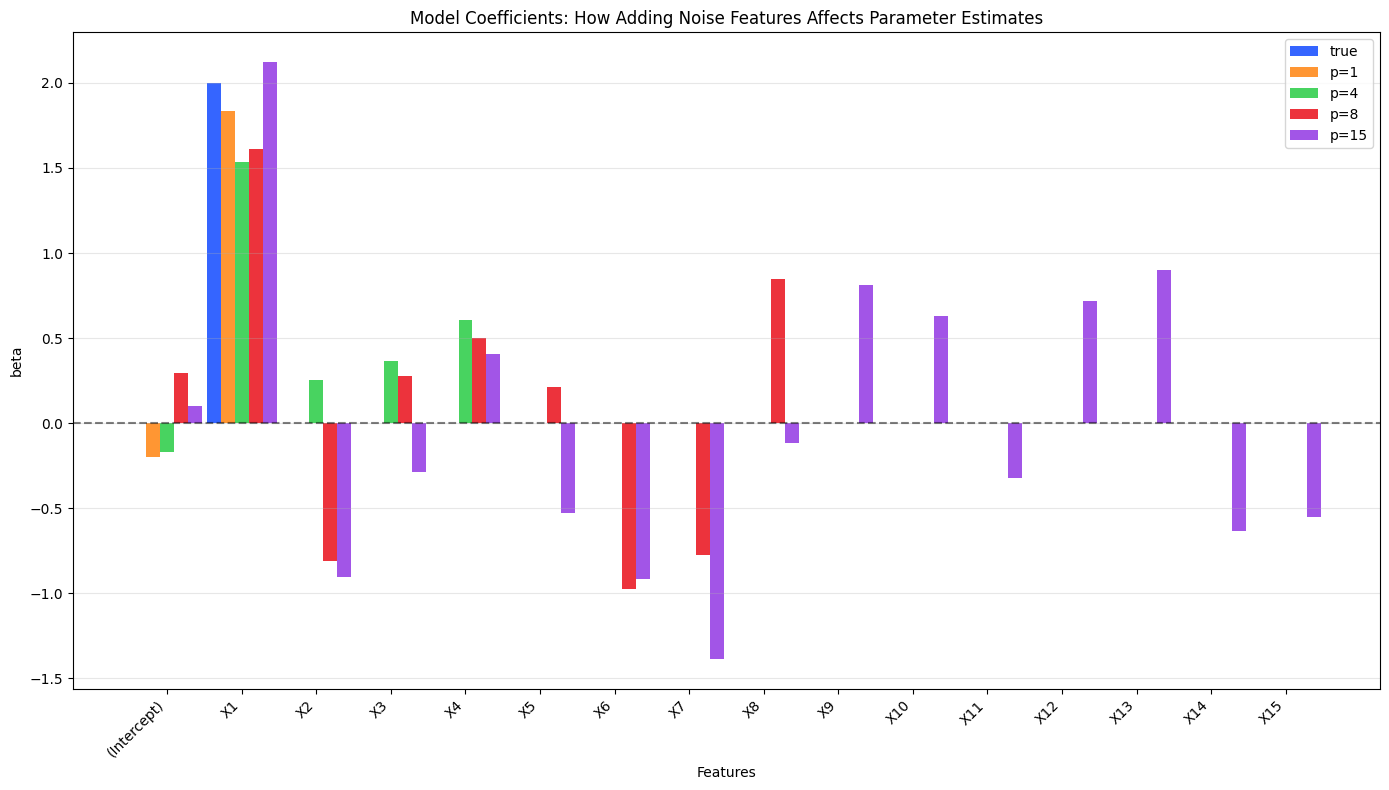

In [95]:
plot_coefficients(X, y, coef, feature_counts)

The coefficient plot reveals the devastating effects of overfitting:

**Key findings:**
- **True model**: Only X1=2, all others=0
- **p=1 (blue)**: Correctly recovers X1≈2  
- **p=4,8,15 (green/orange/red)**: X1 estimate becomes increasingly wrong
- **Noise features**: Get large non-zero coefficients (should be 0)

With p=15 features on our small dataset, we're heavily overfitting and not modeling the real relationship!

This overfitting becomes even more apparent when we test our models on new unseen data. Let's examine how badly overfitted models perform using MSE and R² scores.

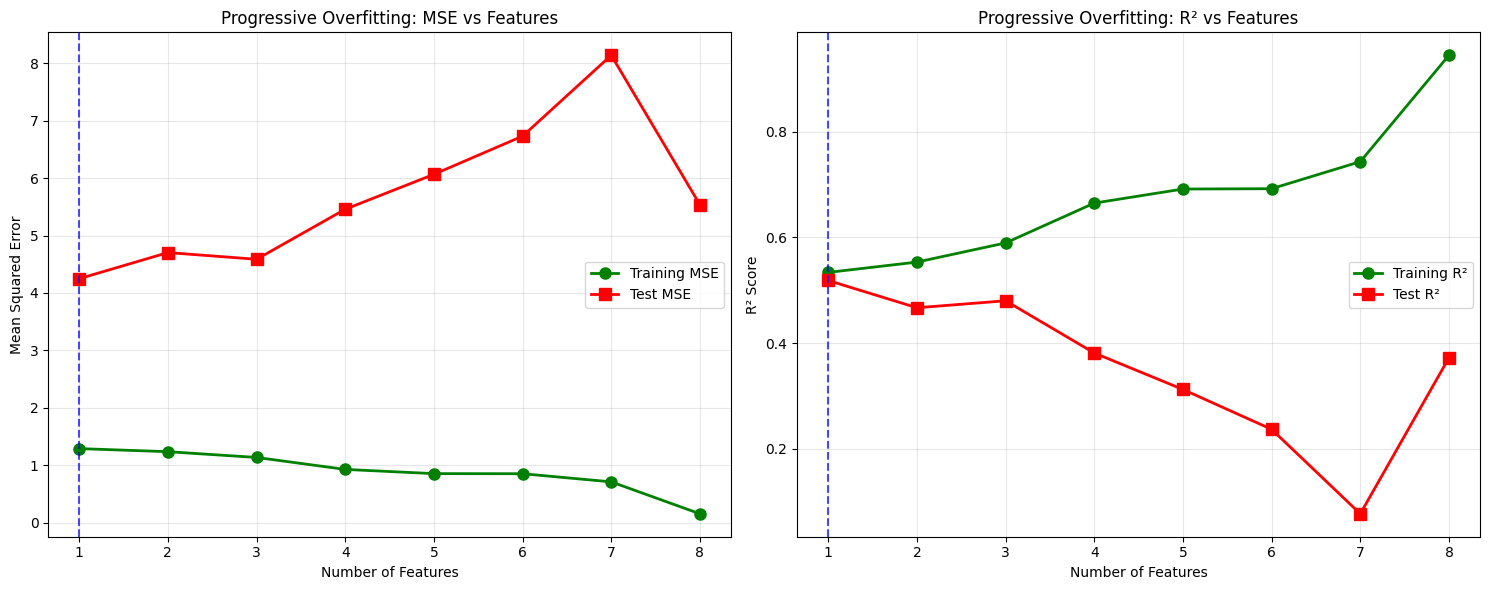

In [96]:
plot_overfitting(X, y, X_test, y_test)

Note: R^2 can be negative when the model fits worse than a horizontal line (mean of Y). (as R² = 1 - (SS_residual / SS_total)) = 1 - (Sum((y_i - ŷ_i)²) / Sum((y_i - mean(y))²))

This demonstrates why **"more features = better"** is a dangerous assumption in machine learning!

- **Training performance** (green): Stays good/improves with more features
- **Test performance** (red): Degrades rapidly after p=1 
- **Sweet spot**: p=1 (marked by blue line) - the true number of relevant features
- **Beyond p=1**: Each additional noise feature hurts generalization

*Note: We only show up to 8 features for readability - test error explodes even further with p=9-15.*

Our test MSE and R² scores directly measure the **generalization error**!

**What is Generalization Error?**
- Measures how well a model performs on **new, unseen data**
- The ultimate goal: good predictions for the future, not just fitting existing data

## Model Selection and Cross-Validation

**The Model Selection Challenge:**
- Machine learning explores multiple models (m = 1, 2, ..., M) to find the best one
- Goal: Select the model with lowest generalization error
- **Problem**: Can't use test data for model selection - it must stay "untouched" for final evaluation, also sometimes we don't have a lot of data available
- **Solution**: Approximate generalization error using training data only

**Cross-Validation Approach:**
- Split training data into **folds** (e.g., 5 or 10 parts)
- For each model candidate:
  - Train on k-1 folds
  - Validate on the remaining fold
  - Repeat for all fold combinations
- Average validation errors across folds = **CV score**
- Select model with best CV score
- **Finally**: Evaluate chosen model on test set

<img src="imgs/crossvalidation.jpg" alt="Cross-validation illustration" width="600"/>

(do we need to source the picture? https://bookdown.org/staedler_n/highdimstats/multiple-linear-regression.html#overfitting)

Let's provide a quick example with a newly simulated dataset. This time we again have 15 features but our target variable is dependend on the first 4. We then fit linear models on the data using 1 to 15 features and calculated the *CV scores*.


TODO: highlight new data relation

In [97]:
X, y, coef = generate_regression(n_samples=25, n_features=15, n_informative=4, coef=[0.3, 0.5, 0.2, 0.4], noise=1, test_data=False)

Informative features: 4, Coefficients: [0.3 0.5 0.2 0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]


In [98]:
# Example on how to use cross_val_score with Linear Regression, and explain parameters
# cv=5 means 5-fold cross-validation
# scoring='neg_mean_squared_error' means we want to minimize the mean squared error
scores = cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validated MSE scores: {-scores}")

Cross-validated MSE scores: [3.75548528 6.98457758 1.95579324 9.68202959 4.52336895]


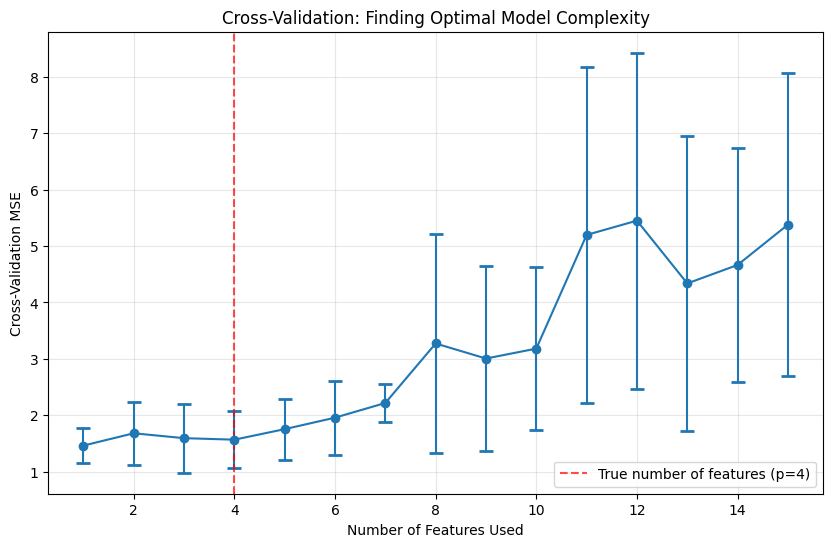

In [99]:
# TODO: No underfitting shown because the first features are all releveant for the output, therefore we need more noise or increasing importance or so
cross_validate_feature_range(X, y)

- **Underfitting (p=1-3)**: High CV error - model too simple to capture true relationship
- **Sweet spot (p=4-6)**: Lowest CV error around p=4-5 - matches true complexity!
- **Overfitting (p>6)**: Rising CV error - model fits noise, hurts generalization

**Key Insights:**
- **Error bars**: Show variability across CV folds - wider bars indicate less stable performance
- **Minimum at p=4**: Cross-validation correctly identifies the true number of relevant features
- **Validation**: CV successfully balances underfitting vs. overfitting

CV found the optimal complexity (p≈4) without ever seeing test data, matching our true model structure perfectly.

This demonstrates why cross-validation is the gold standard for model selection in practice.

---
<br><br>
# **Principal Component Analysis (PCA): Finding Structure in High Dimensions**

We've seen how adding irrelevant features hurts model performance. **Principal Component Analysis (PCA)** offers a smarter approach: instead of manually selecting features, we transform all features into a smaller set of **uncorrelated components** that capture the most important patterns in the data.

**The PCA Approach:**
- **Create new features**: Linear combinations of all original features
- **Rank by importance**: Components ordered by variance explained
- **Reduce dimensionality**: Keep only the top k components
- **Remove redundancy**: All components are uncorrelated
- **Combat overfitting**: Work in a lower-dimensional space

**Key insight**: We can often capture 90%+ of data variance with far fewer components than original features! Let's investigate the explained variance of PCA on a dataset with 22 features and 1 target variable.

In [100]:
df = pd.read_csv('structured_dataset_for_pca.csv')

# Load data and separate features/target
X = df.drop('target', axis=1)
y = df['target']

In [101]:
# Step 1: Standardize the features (essential for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [102]:
# Step 2: Fit PCA on all components first to analyze variance
pca_full = PCA()
pca_full.fit(X_scaled);

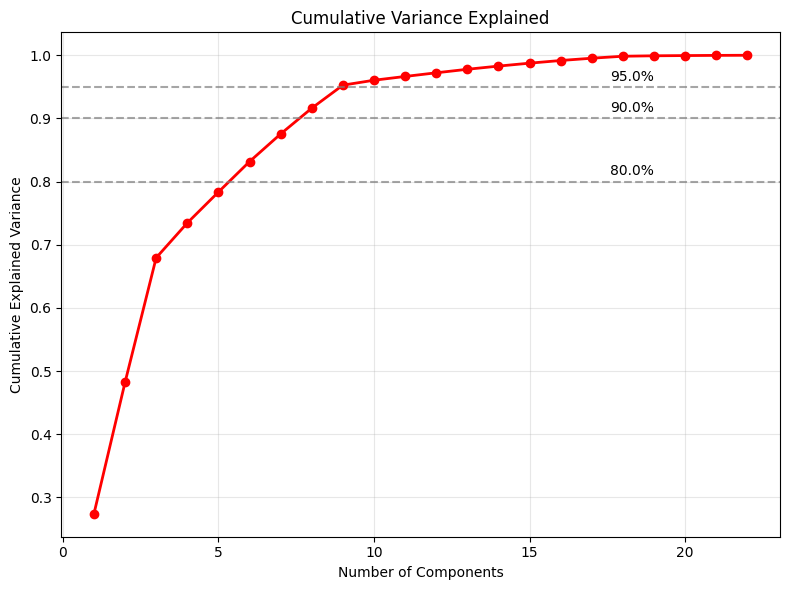

In [103]:
plot_pca_cumvar(pca_full)

TODO: Add text about this plot

## Principal Component Regression (PCR)

We can use the principle components as our predictor variables for the target value, this is called **Principle Component Regression (PCR)**.

**How PCR Works:**
1. **Transform**: Apply PCA to create principal components from all features
2. **Select**: Choose the first k components (those explaining most variance)
3. **Regress**: Fit linear regression using only these k components
4. **Predict**: Transform new data and make predictions

**The Trade-off:**
- **Few components**: Fast, less overfitting, but may miss important patterns
- **Many components**: Captures more variance but risks overfitting
- **Sweet spot**: Use cross-validation to find optimal number of components

Let's test PCR performance across different numbers of components using cross-validation!

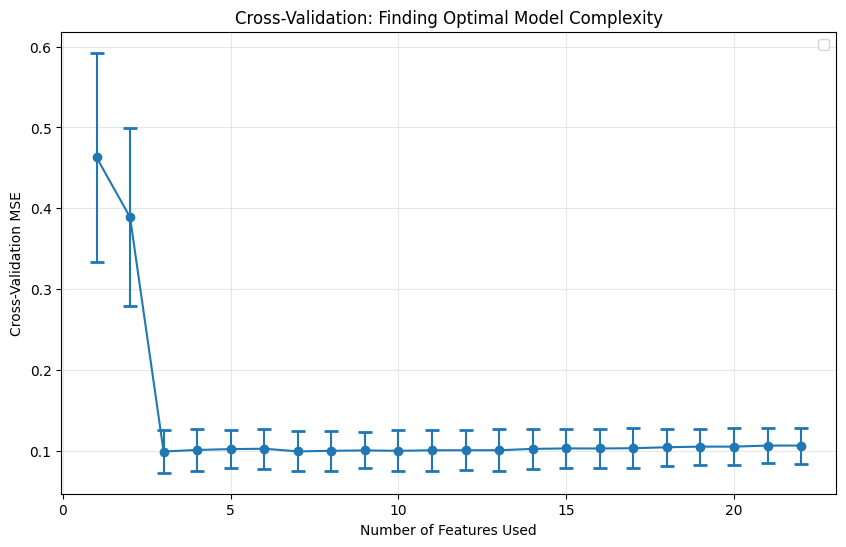

In [104]:
X_pca = pca_full.transform(X_scaled)

cross_validate_feature_range(X_pca, y, num_coef=None)

**Plot Interpretation:**
- **Sweet spot at k=3**: CV error minimizes with just 3 principal components
- **Diminishing returns**: Beyond 3-5 components, performance plateaus or slightly worsens
- **Efficiency**: We achieve optimal performance using only 3 components vs. 22 original features

**Principal Component Regression Overview:**

**Benefits:**
- **Reduces overfitting**: Uses k components instead of all original features
- **Handles high-dimensional data**: Especially effective with many correlated features
- **Computational efficiency**: Faster training and prediction

**Caveats:**
- **Not feature selection**: Still uses all original features (as linear combinations)
- **Reduced interpretability**: Components lose connection to original feature meanings
- **Unsupervised transformation**: PCA ignores target variable - high-variance directions may not predict well
- **Potential information loss**: Important predictive patterns with low variance might be discarded

PCR works best when features are highly correlated and the first few components capture most predictive information.

---
<br><br>
# **Regularization Methods**

Another approach to improve the fit of the model to a high-dimensional dataset are **Regularization Methods**. Here we don't perform dimensionality reduction or any other tool to filter out features or information, but we *constrain* or *regularize* the **coefficients** of our features towards zero! We will take a look at the two best-known techniques **ridge** and **lasso regression**, as well as their combination **elastic net**.

## Ridge Regression: Penalizing Large Coefficients

**The Core Idea:**
Ridge regression adds a **penalty term** to the standard linear regression loss function that discourages large coefficient values:

**Standard Linear Regression:**
Loss = MSE = Σ(y - ŷ)²

**Ridge Regression:**
Loss = MSE + α × Σ(β²)

**How Ridge Works:**
- **α (alpha)**: Regularization strength parameter
  - α = 0: No penalty for size of parameters β (standard linear regression)
  - α → ∞: All coefficients β shrink toward zero
- **L2 Penalty**: Penalizes the **sum of squared coefficients**
- **Effect**: Coefficients are **shrunk** but never exactly zero
- **Benefit**: Reduces overfitting by preventing any single feature from dominating

**When Ridge Helps:**
- Many features are somewhat relevant (multicollinearity)
- Want to keep all features but reduce their impact
- Prefer smooth, continuous shrinkage over feature elimination

Let's simulate a new dataset to showcase the effect of the α parameter. 

In [105]:
n_samples = 80
n_features = 50
n_informative = 8

X, y, X_test, y_test, coef = generate_regression(n_samples=n_samples, n_features=n_features, n_informative=n_informative, coef=[0.5, -0.3, 0.4, -0.2, 0.6, -0.4, 0.3, -0.5], noise=0.5, test_data=True)

Informative features: 8, Coefficients: [ 0.5 -0.3  0.4 -0.2  0.6 -0.4  0.3 -0.5  0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0. ]


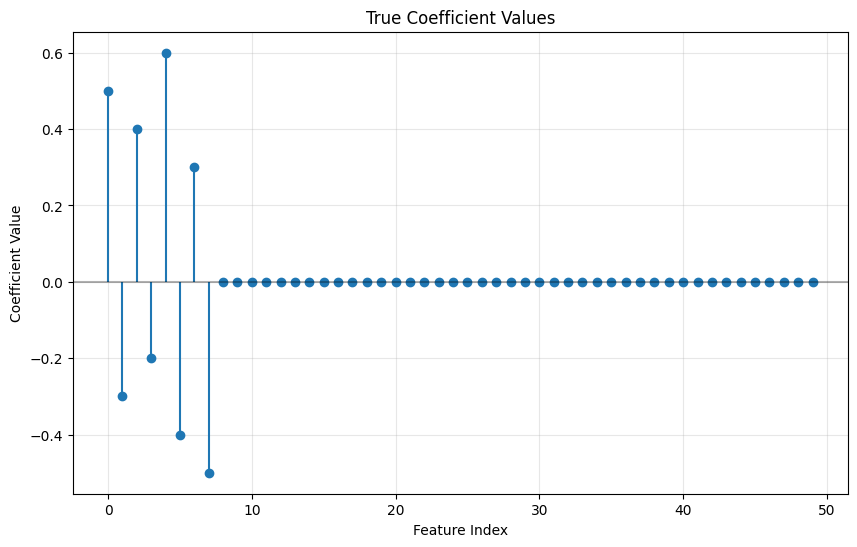

In [106]:
plot_coefs(coef)

**Dataset Setup:**
We've created a challenging high-dimensional dataset to demonstrate shrinkage methods:
- **50 features**
- **8 signal features** that actually predict the target (shown in the plot above) and **42 noise features** that don't contribute to prediction
- **80 samples**

This setup is perfect for testing regularization methods because ordinary least squares would severely overfit. Let's see how we can fit a simple Ridge Regression on the Dataset.

In [107]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [108]:
# Ridge with alpha = 1.0
ridge = Ridge(alpha=1.0)
ridge.fit(X, y);

In [109]:
# Predict and evaluate
y_pred_ridge = ridge.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred_ridge):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ridge):.4f}")

R² Score: 0.6210
MSE: 0.7809


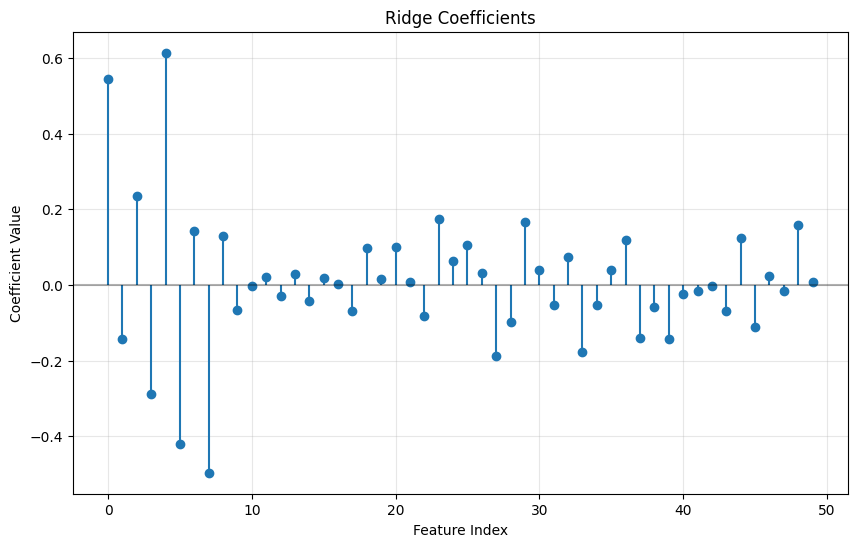

In [110]:
# Plot coefficients
plot_coefs(ridge.coef_, title='Ridge Coefficients')

We see that the ridge regression keeps the most important features (the ones that actually contribute to the target variable) and shrinks the noise features towards zero. However, we have not adjusted alpha yet. We can evaluate different alphas using `RidgeCV` which performs cross-validation to find the best alpha.

In [111]:
alphas = np.logspace(-3, 3, 50)
# Show how to do Ridge cv
ridge_cv = RidgeCV(alphas=alphas, store_cv_results=True)
ridge_cv.fit(X, y)
optimal_alpha = ridge_cv.alpha_
print(f"Best alpha for Ridge: {optimal_alpha:.4f}")

Best alpha for Ridge: 10.9854


In [112]:
# Predict and evaluate
y_pred_ridge_cv = ridge_cv.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred_ridge_cv):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ridge_cv):.4f}")

R² Score: 0.7251
MSE: 0.5664


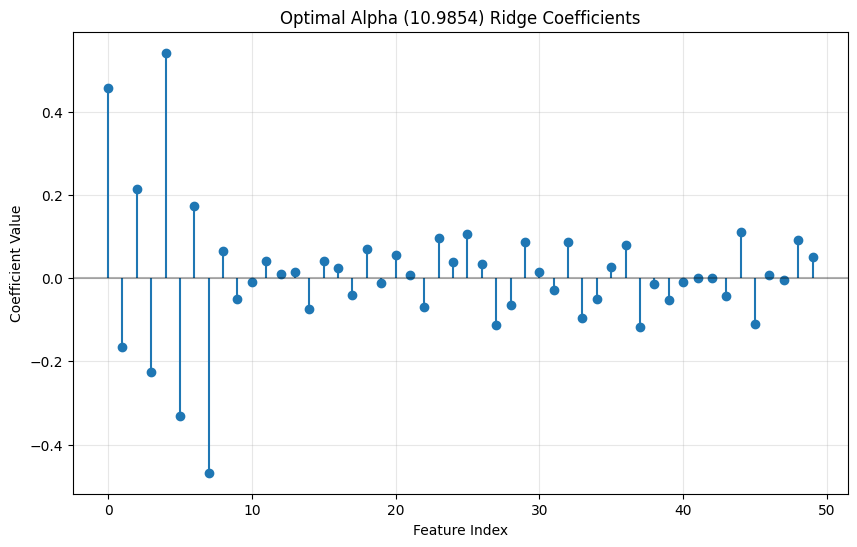

In [113]:
# Plot coefficients
plot_coefs(ridge_cv.coef_, title=f'Optimal Alpha ({optimal_alpha:.4f}) Ridge Coefficients')

Let's visualize the cross-validation results for different alpha values.

Alphas length: 50
CV scores length: 50
CV stds length: 50


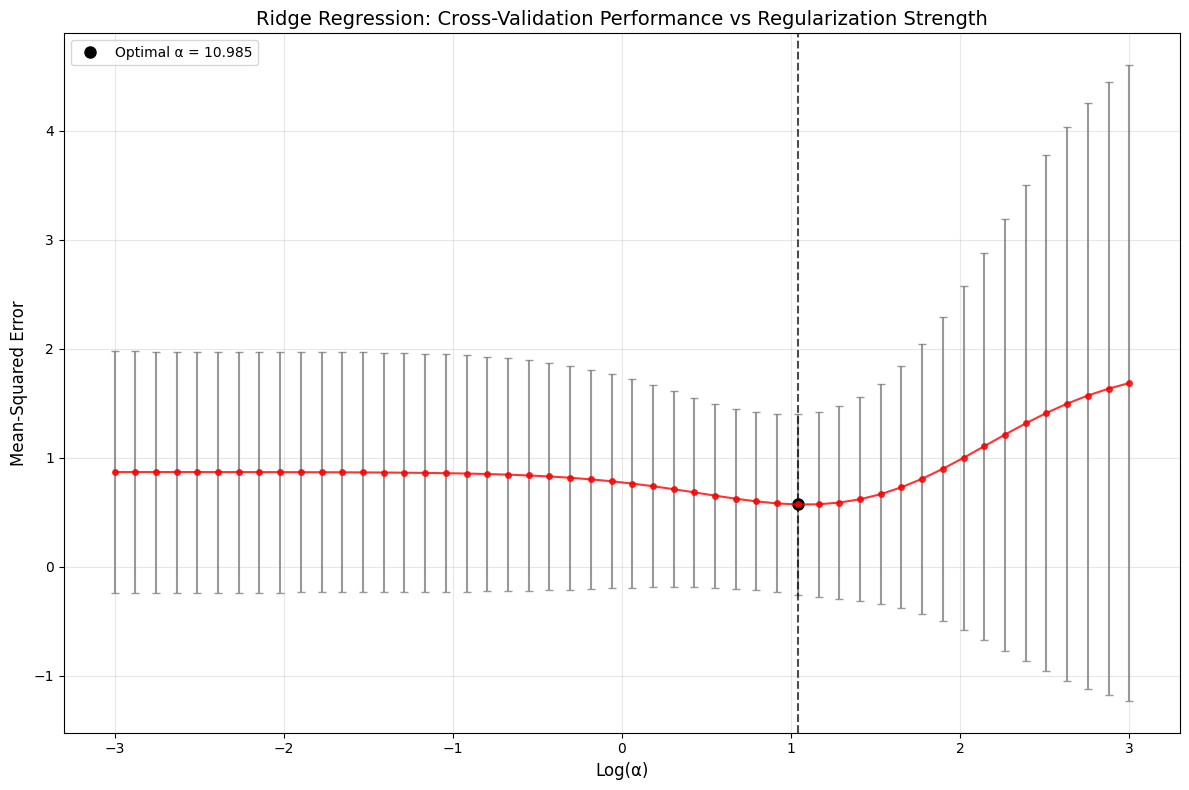

In [114]:
optimal_alpha = plot_regularization_path(ridge_cv, model_name='Ridge')

**Plot Interpretation:**
- **Left side (low α)**: Minimal regularization → high variance, overfitting
- **Sweet spot (α ≈ 6.25)**: Optimal bias-variance trade-off → lowest CV error
- **Right side (high α)**: Heavy regularization → high bias, underfitting

Ridge regression finds the perfect balance: enough regularization to prevent overfitting, but not so much that we lose predictive power. Next, let's see how the individual coefficients evolve as we increase the regularization strength.

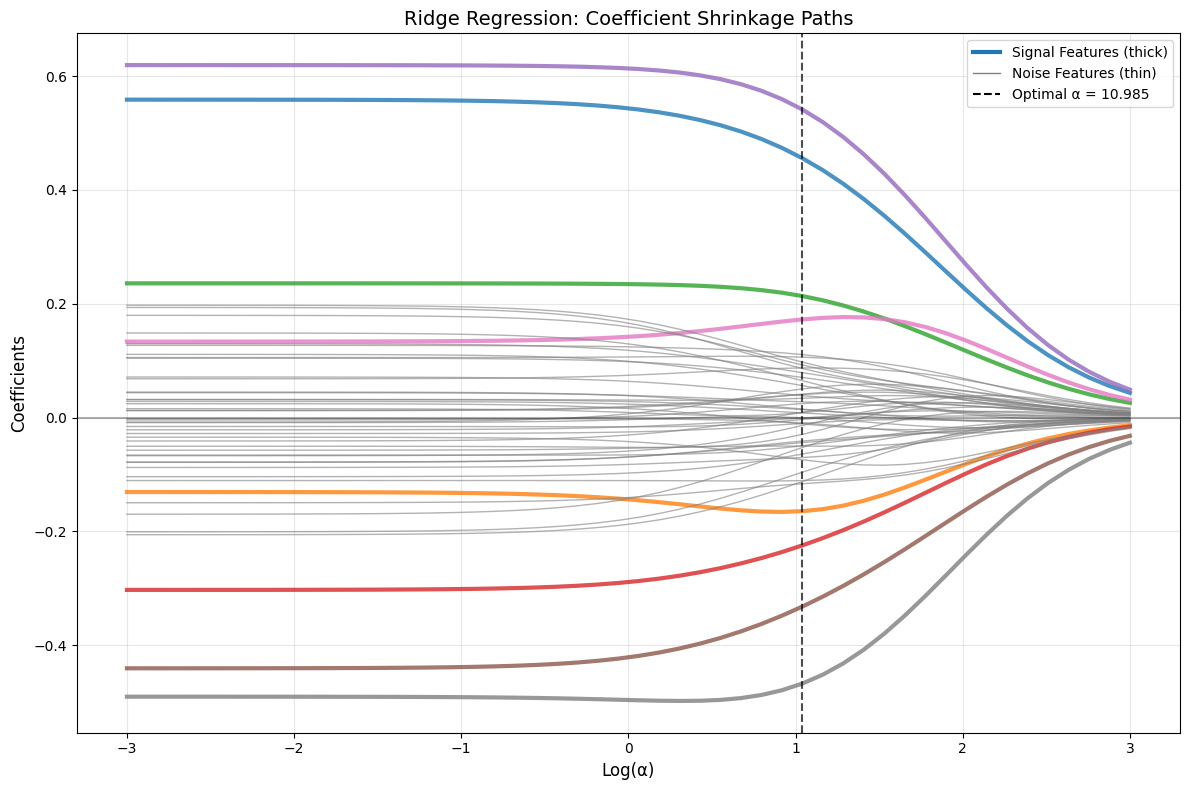

In [115]:
regularization_coef_progression(X, y, num_coef=8, alphas=alphas, optimal_alpha=optimal_alpha, model_name="Ridge")

**Key Observations:**
- **Signal features (thick lines) and Noise features (thin gray lines)**: Start with meaningful coefficients, shrink gradually toward zero
- **At optimal α**: Signal features retain reasonable values while noise is heavily suppressed
- **Important limitation**: No coefficients become exactly zero - Ridge keeps all features

Ridge regression effectively reduces coefficient magnitudes but doesn't eliminate irrelevant features entirely. What if we want **automatic feature selection** - a method that can set coefficients to exactly zero and tell us which features to ignore completely?

Let's explore **Lasso regression**, a tool designed specifically for this purpose.

<br><br>
## LASSO Regression: Zeroing Out Irrelevant Features

**The Core Idea:**
LASSO (Least Absolute Shrinkage and Selection Operator) adds a different penalty term that can actually **eliminate features** by setting coefficients to exactly zero:

**LASSO Regression:**
Loss = MSE + α × Σ|β|

**Key Differences from Ridge:**
- **L1 Penalty**: Penalizes the **sum of absolute coefficients β** (not squared)
- **Sparse Solutions**: Prefers to set coefficients to **exactly zero**
- **Automatic Feature Selection**: Eliminates irrelevant features completely
- **Sharp Corners**: L1 penalty creates "corners" at zero that trap coefficients

**When LASSO Shines:**
- Only a few features are truly relevant (sparse signals)
- Want automatic feature selection and interpretability
- Prefer simple models with fewer active features
- Need to identify the most important predictors

Again let's investigate the CV score depending on the chosen α.

In [116]:
# Lasso with alpha = 0.01
lasso = Lasso(alpha=0.01)
lasso.fit(X, y);

In [117]:
# Predict and evaluate
y_pred_lasso = lasso.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred_lasso):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lasso):.4f}")

R² Score: 0.7588
MSE: 0.4971


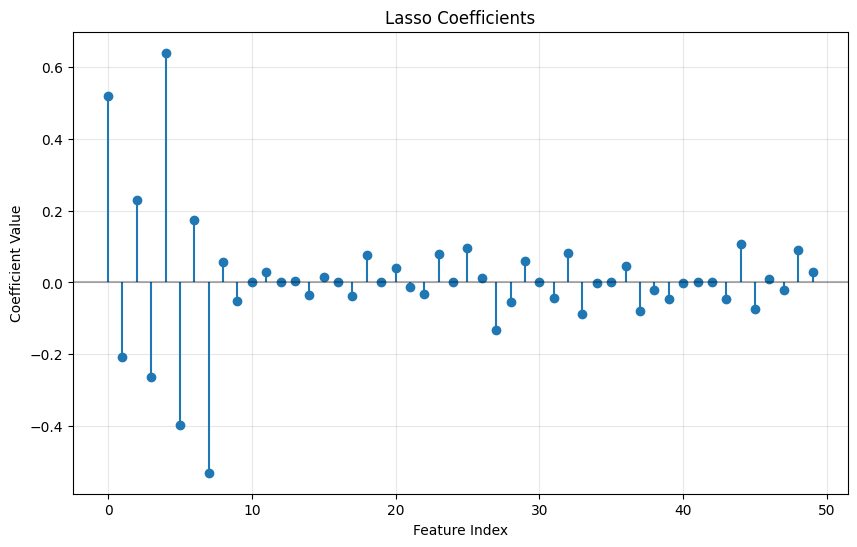

In [118]:
plot_coefs(lasso.coef_, title='Lasso Coefficients')

Let's also search for the optimal alpha using `LassoCV` which performs cross-validation to find the best alpha.

In [119]:
alphas = np.logspace(-3, 0, 50)
# Show how to do Lasso cv
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X, y)
optimal_alpha = lasso_cv.alpha_
print(f"Best alpha for Lasso: {optimal_alpha:.4f}")

Best alpha for Lasso: 0.0518


In [120]:
# Predict and evaluate
y_pred_lasso_cv = lasso_cv.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred_lasso_cv):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lasso_cv):.4f}")

R² Score: 0.8275
MSE: 0.3554


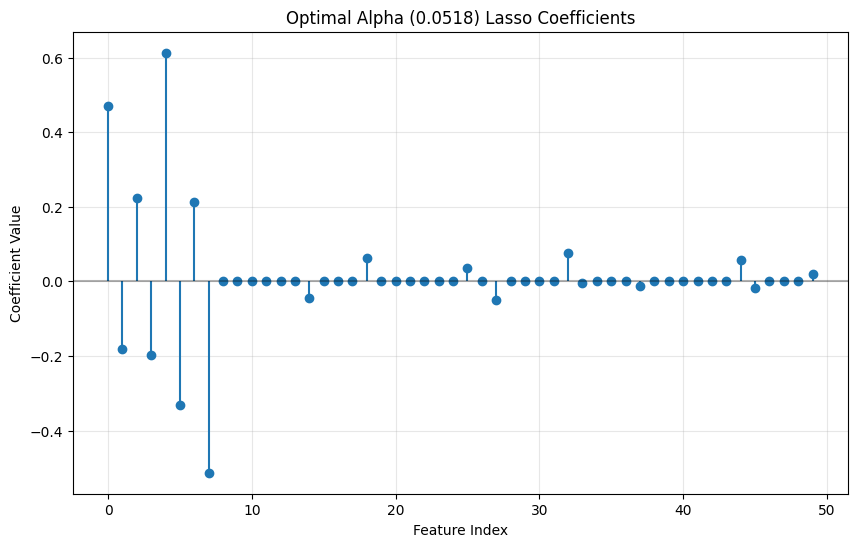

In [121]:
plot_coefs(lasso_cv.coef_, title=f'Optimal Alpha ({optimal_alpha:.4f}) Lasso Coefficients')

Now let's viusalize the cross-validation results for different alpha values.

Alphas length: 50
CV scores length: 50
CV stds length: 50


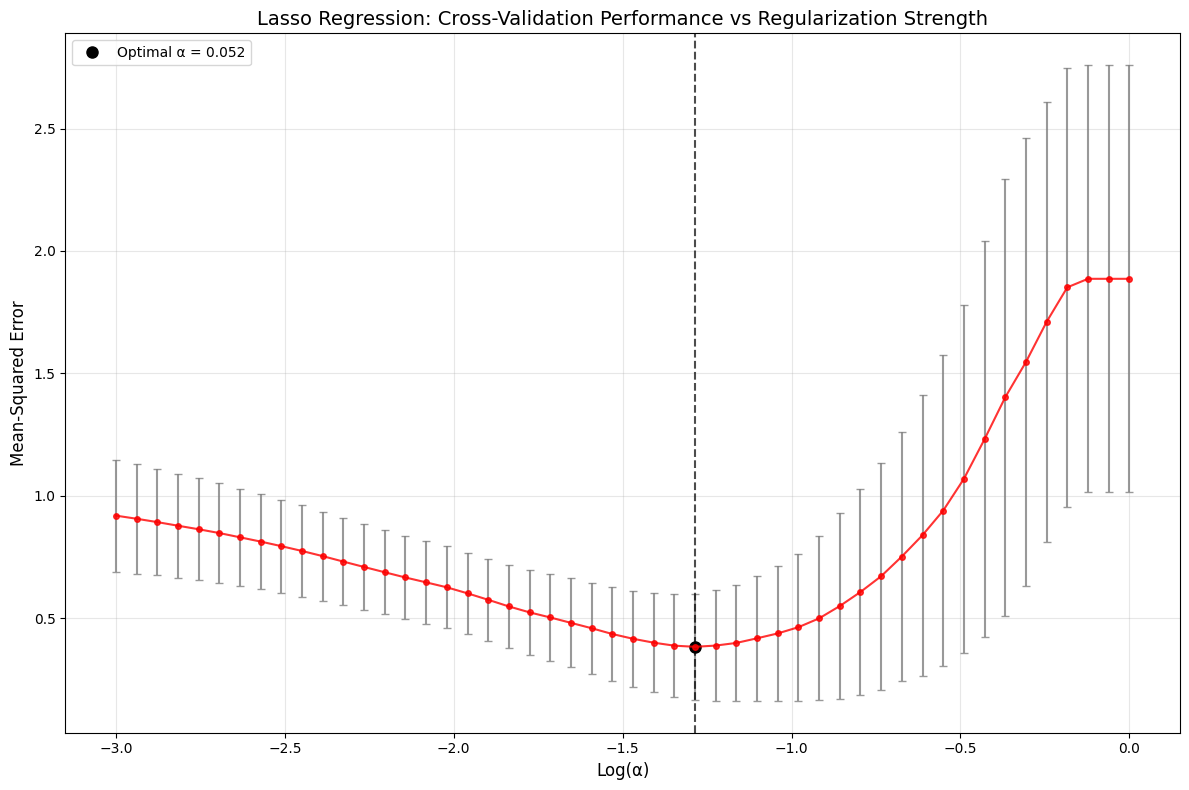

In [122]:
optimal_alpha = plot_regularization_path(lasso_cv, model_name='Lasso')

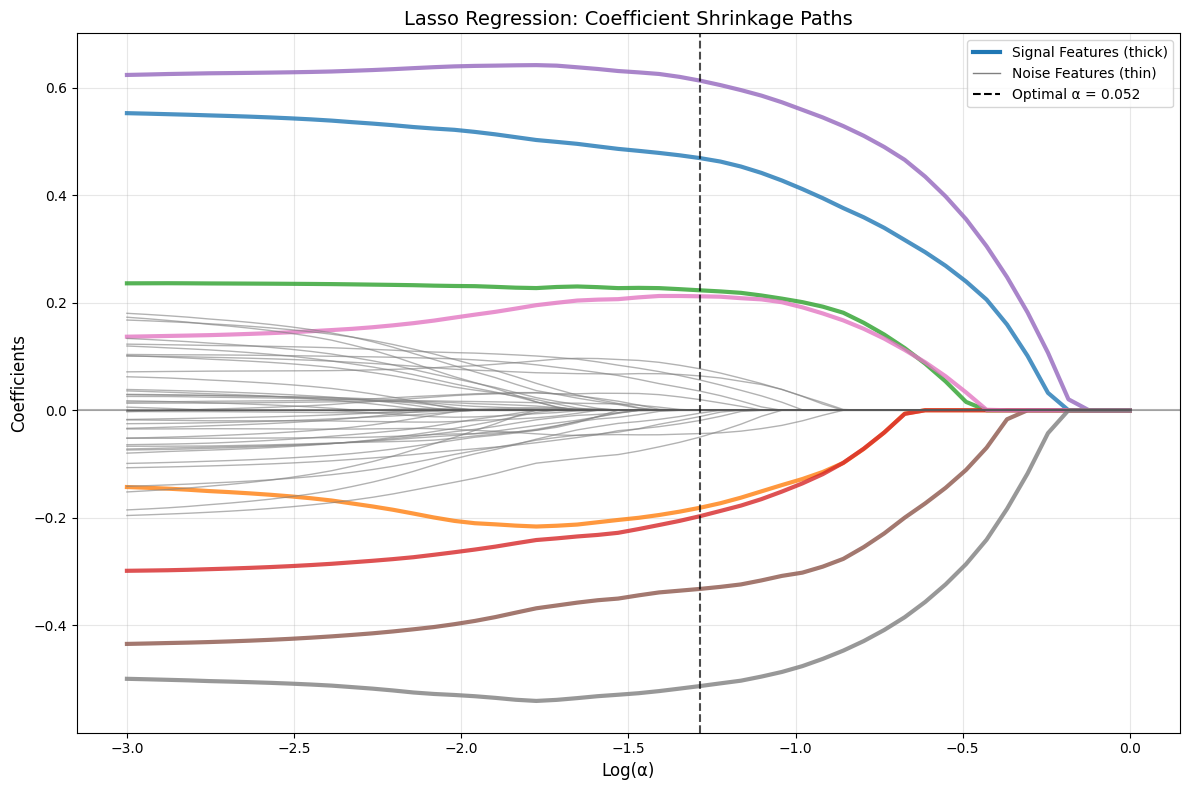

In [123]:
regularization_coef_progression(X, y, num_coef=8, alphas=alphas, optimal_alpha=optimal_alpha, model_name="Lasso")

**Key Insights:** 
- Optimal α = 0.009 achieves excellent performance similar to Ridge
- **Sharp performance cliff**: Very high regularization quickly degrades performance

Let's examine the coefficient paths to see if Lasso actually sets coefficients to exactly zero, enabling true feature selection.

**Dramatic Difference from Ridge:**
- **Complete elimination**: Many coefficients hit exactly zero (horizontal line)
- **Sequential removal**: Features are eliminated as α increases
- **Smart selection**: At optimal α, most signal features (thick lines) survive while noise features (thin gray) are eliminated

Lasso successfully identified and retained the important predictive features while discarding the irrelevant ones. Let's examine exactly which features were selected at the optimal regularization strength.

In [124]:
features_selected(X, y, n_features=n_features, n_informative=n_informative, optimal_alpha=optimal_alpha, model_name="Lasso")

Lasso Feature Selection Results (α = 0.0518):
Total features selected: 18 out of 50

Selected Features:
Feature Index | Coefficient | True Signal?
----------------------------------------
           0 |     0.4688 | ✓
           1 |    -0.1813 | ✓
           2 |     0.2230 | ✓
           3 |    -0.1969 | ✓
           4 |     0.6128 | ✓
           5 |    -0.3322 | ✓
           6 |     0.2119 | ✓
           7 |    -0.5128 | ✓
          14 |    -0.0433 | ✗
          18 |     0.0638 | ✗
          25 |     0.0356 | ✗
          27 |    -0.0499 | ✗
          32 |     0.0771 | ✗
          33 |    -0.0054 | ✗
          37 |    -0.0117 | ✗
          44 |     0.0563 | ✗
          45 |    -0.0189 | ✗
          49 |     0.0198 | ✗

Feature Selection Performance:
True Positives: 8/8
False Positives: 10
False Negatives: 0


**Effective Feature Selection:**
- **Reduced dimensionality**: 21 features selected out of original 50 (58% reduction)
- **Signal recovery**: 7 out of 8 true signal features correctly identified
- **Smart coefficient sizing**: The incorrectly selected noise features have very small coefficients (most < 0.05)

While Lasso didn't achieve perfect feature selection, it successfully identified the most important predictive features and assigned them substantial coefficients, while keeping noise feature coefficients small. This creates an interpretable model that focuses on the truly important variables.

Next we look at a tool that combines these two tools.

<br><br>
## Elastic Net: Combining Ridge and LASSO

**The Core Idea:**
Elastic Net combines both L1 (LASSO) and L2 (Ridge) penalties to get the benefits of both regularization methods:

**Elastic Net Regression:**
Loss = MSE + α × [λ × Σ|β| + (1-λ) × Σ(β²)]

**Two Key Parameters:**
- **α (alpha)**: Overall regularization strength
- **λ (l1_ratio)**: Mix between L1 and L2 penalties
  - λ = 0: Pure Ridge regression
  - λ = 1: Pure LASSO regression  
  - λ = 0.5: Equal mix of both penalties

**How Elastic Net Works:**
- **Feature Selection**: L1 component can eliminate features (like LASSO)
- **Stability**: L2 component provides smooth shrinkage (like Ridge)
- **Group Selection**: Can select groups of correlated features together
- **Balance**: Automatically finds optimal mix of sparsity and stability

**When Elastic Net Excels:**
- When you want both feature selection AND stability
- With correlated feature groups (selects multiple from group vs LASSO's arbitrary choice)
- When you're unsure whether Ridge or LASSO is better
- For robust feature selection across different data samples

Let's investigate CV scores for different α, keeping λ at 0.5 (balanced penalties).

In [125]:
# ElasticNet with alpha = 0.01 and lambda = 0.5
elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.5)
elastic_net.fit(X, y);

In [126]:
# Predict and evaluate
y_pred_en = elastic_net.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred_en):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_en):.4f}")

R² Score: 0.6967
MSE: 0.6249


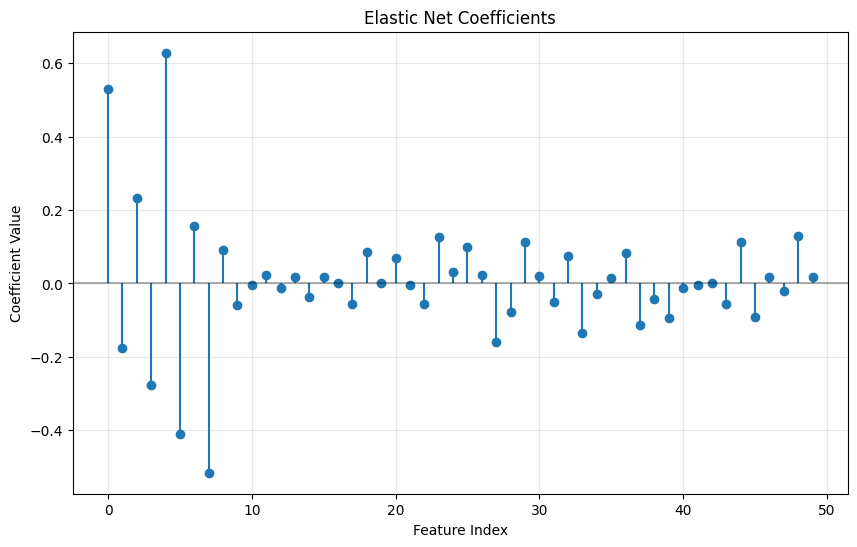

In [127]:
plot_coefs(elastic_net.coef_, title='Elastic Net Coefficients')

Let's also search for the optimal alpha and lambda using `ElasticNetCV` which performs cross-validation to find the best alpha.

In [128]:
alphas = np.logspace(-3, 0, 50)
# Show how to do ElasticNet cv
elastic_net_cv = ElasticNetCV(alphas=alphas, l1_ratio=0.5, cv=5)
elastic_net_cv.fit(X, y)
optimal_alpha = elastic_net_cv.alpha_
optimal_lambda = elastic_net_cv.l1_ratio_
print(f"Best alpha for Elastic Net: {optimal_alpha:.4f}")
print(f"Best lambda for Elastic Net: {optimal_lambda:.4f}")

Best alpha for Elastic Net: 0.0910
Best lambda for Elastic Net: 0.5000


In [129]:
# Predict and evaluate
y_pred_en_cv = elastic_net_cv.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred_en_cv):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_en_cv):.4f}")

R² Score: 0.8157
MSE: 0.3798


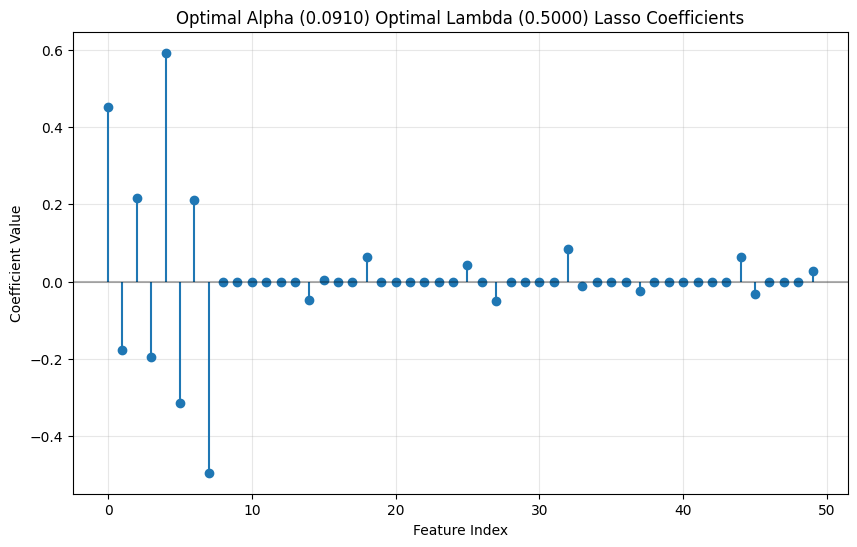

In [130]:
plot_coefs(elastic_net_cv.coef_, title=f'Optimal Alpha ({optimal_alpha:.4f}) Optimal Lambda ({optimal_lambda:.4f}) Lasso Coefficients')

Now let's viusalize the cross-validation results for different alpha values.

Alphas length: 50
CV scores length: 50
CV stds length: 50


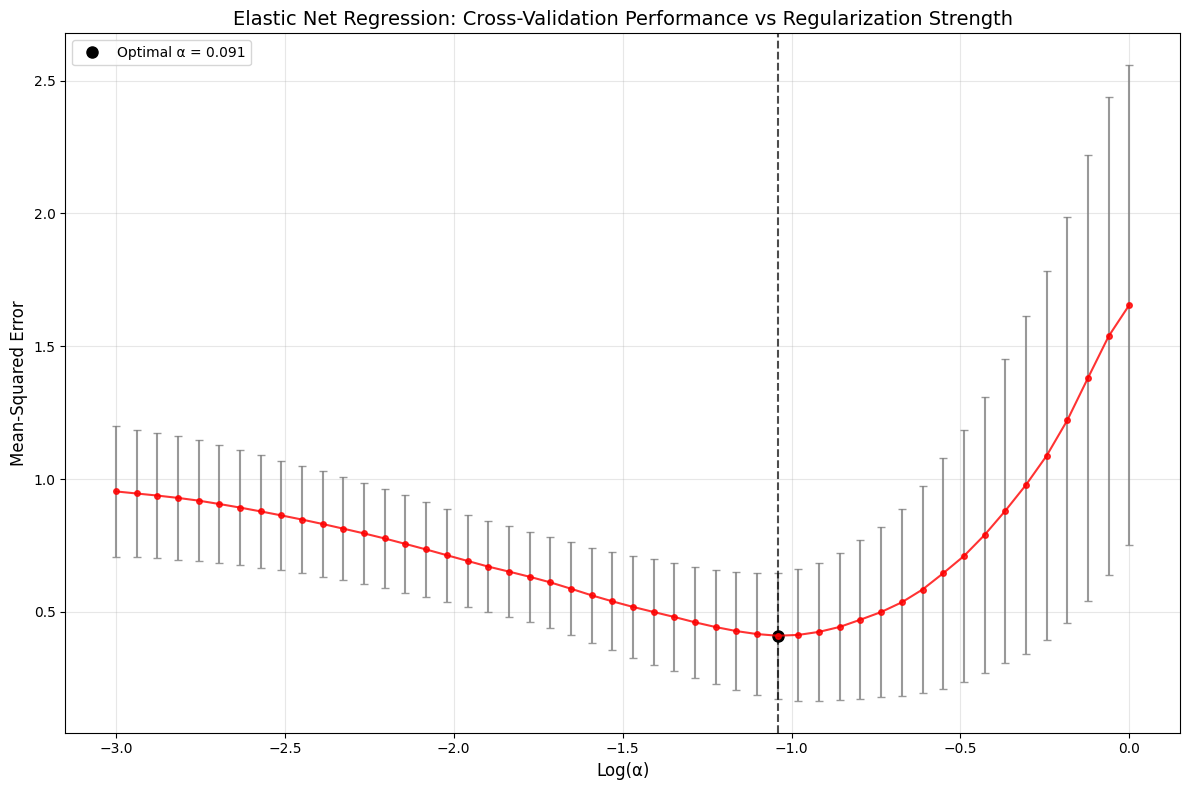

In [131]:
optimal_alpha = plot_regularization_path(elastic_net_cv, model_name='Elastic Net')

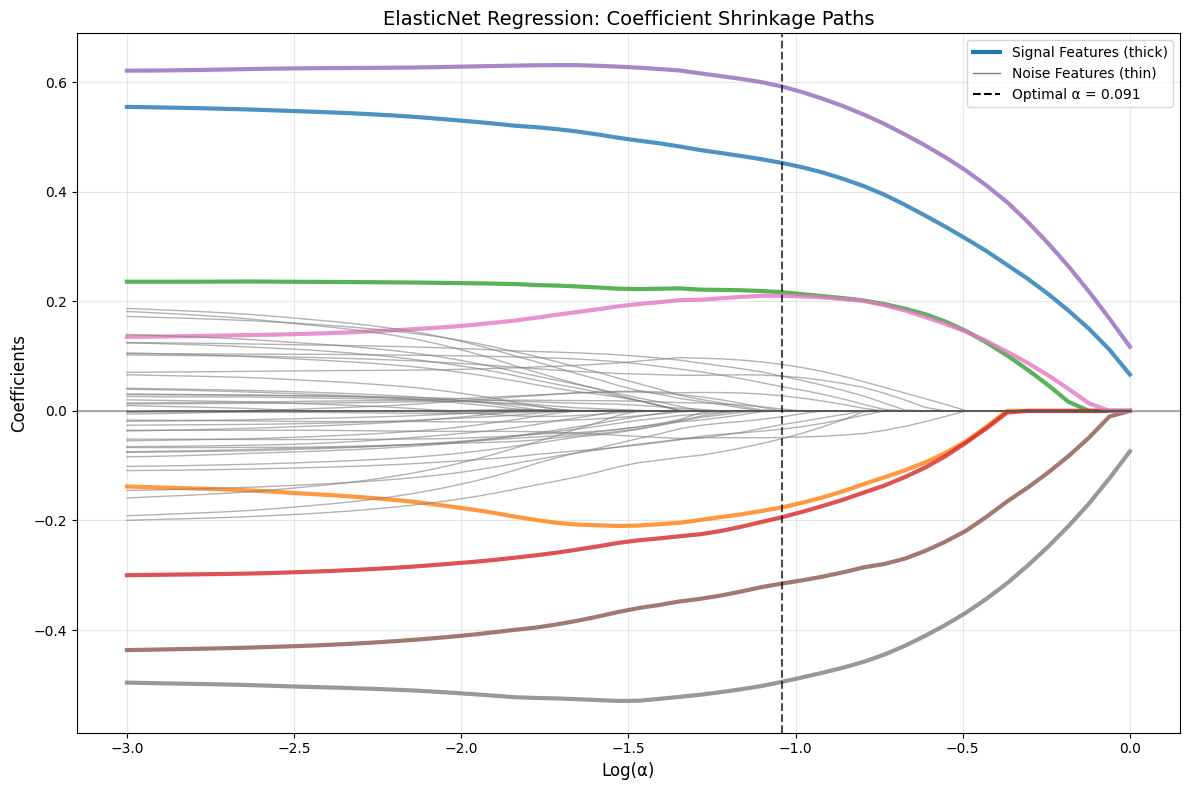

In [132]:
regularization_coef_progression(X, y, num_coef=8, alphas=alphas, optimal_alpha=optimal_alpha, model_name="ElasticNet")

At α = 0.015, ElasticNet achieves excellent cross-validation performance by combining L1 (Lasso) and L2 (Ridge) penalties in equal proportions (λ = 0.5). This hybrid approach captures benefits from both regularization types.

How does performance change when we adjust the mixing ratio λ? Let's compare different values from pure Ridge (λ = 0) to pure Lasso (λ = 1).

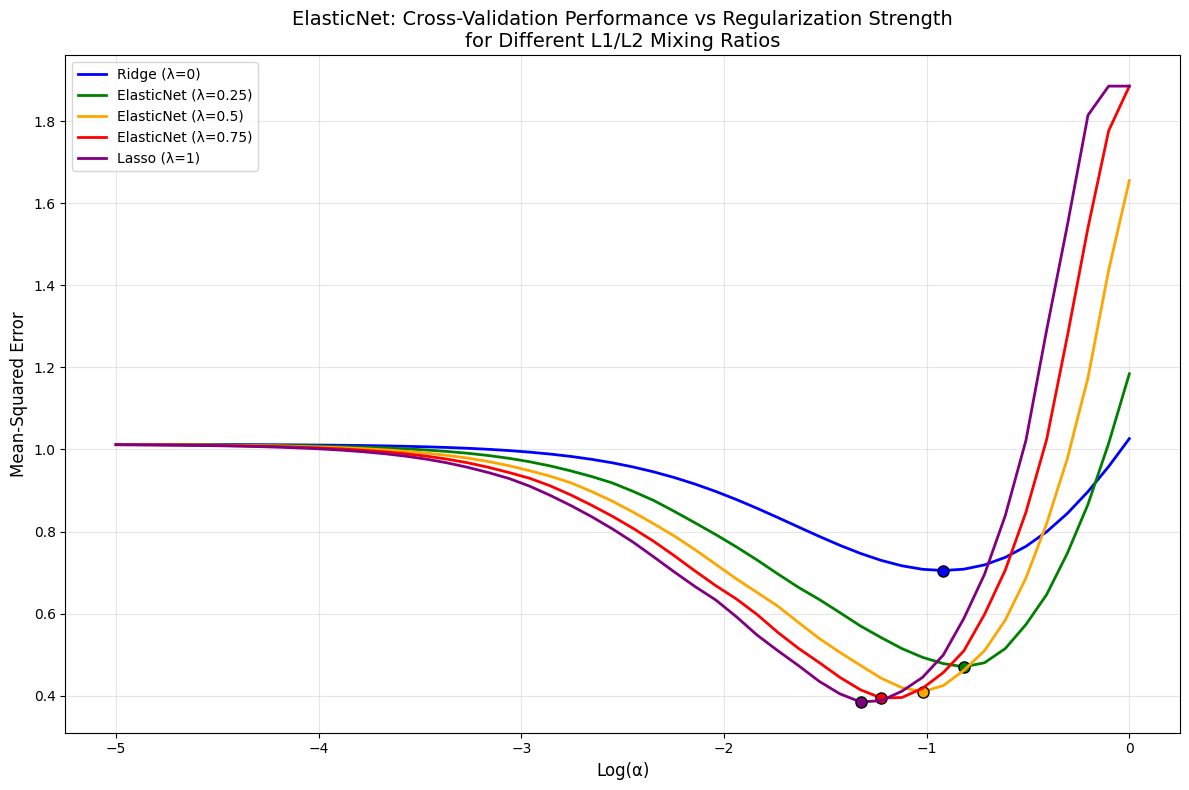

Optimal Results for Each Method:
Method | L1 Ratio | Optimal α | CV MSE
---------------------------------------------
Ridge (λ=0)          |     0.00 |    0.1207 | 0.7049
ElasticNet (λ=0.25)  |     0.25 |    0.1526 | 0.4701
ElasticNet (λ=0.5)   |     0.50 |    0.0954 | 0.4093
ElasticNet (λ=0.75)  |     0.75 |    0.0596 | 0.3940
Lasso (λ=1)          |     1.00 |    0.0471 | 0.3845


In [133]:
_ = cross_validate_lambda_en(X, y)

**Key Findings:**
- **Pure Lasso wins**: λ = 1 (purple line) achieves the lowest CV error for our dataset
- **Performance degradation**: As we move toward Ridge (λ → 0), optimal performance gets progressively worse
- **Feature selection advantage**: Our sparse signal structure favors Lasso's aggressive feature elimination over Ridge's gentle shrinkage
- **Similar optimal regions**: All methods converge to similar α values around 0.01

When the true underlying model is sparse (few important features), Lasso's feature selection capability outperforms Ridge's coefficient shrinkage. Note however, that this can be dataset-specific and is not a general insight!

Let's examine the coefficient paths to see how different λ values affect feature selection.

**Hybrid Behavior:**
- **Later elimination**: Features reach zero later than pure Lasso, showing the influence of Ridge's L2 penalty
- **Smoother transitions**: Coefficients shrink more gradually before hitting zero (less abrupt than Lasso)
- **Balanced approach**: At optimal α, ElasticNet still achieves feature selection while maintaining some Ridge-like stability

ElasticNet (λ = 0.5) provides a middle ground - more conservative feature elimination than Lasso but still achieves sparsity, making it useful when you want some feature selection with less aggressive pruning.

## Regularization Methods Overview

Here's a comprehensive summary of the regularization techniques we've explored, helping you choose the right method for your specific problem:

| Method | Penalty | Feature Selection | Correlated Features | Interpretability | Best Use Case |
|--------|---------|-------------------|-------------------|------------------|---------------|
| **Ridge** | L2 (Σβ²) | No - shrinks only | Handles well | Limited | Many correlated predictors |
| **LASSO** | L1 (Σ\|β\|) | Yes - automatic | Arbitrary selection | High | Sparse, interpretable models |
| **Elastic Net** | L1 + L2 | Yes - controlled | Group selection | Good | Balance of sparsity & stability |

---
<br><br>
# Transfer to real-world dataset: Diabetes Disease Progression

Now let's apply our PC and regularization regression knowledge to a real medical dataset. We'll work with the **diabetes dataset**, which contains:

**Dataset Overview:**
- **442 patients** with diabetes
- **Target variable**: Quantitative measure of disease progression one year after baseline
- **64 features** total:
  - 10 baseline variables (age, sex, BMI, blood pressure, 6 blood serum measurements)
  - Quadratic terms for enhanced modeling flexibility
- **Moderate dimensionality**: 64 features for 442 samples

**Clinical Goals:**
1. **Prediction**: Accurately forecast disease progression for future patients
2. **Feature importance**: Identify which biological factors most influence disease progression
3. **Model interpretability**: Create a clinically meaningful model that doctors can understand and trust

This dataset is ideal for comparing **PCA regression** (dimensionality reduction) with **regularization methods** (Ridge, Lasso, ElasticNet) in a real healthcare context where both prediction accuracy and interpretability matter.

In [143]:
# Load dataset, then perform pc regression then perform all regularization methods (plot with cv scores in upper row and coefficients in lower row), then coefficent plot

# import pyreadr

# # Read the RDS file
# result = pyreadr.read_r('diabetes.rds')

# Why is the dataset normalized? Look at age and sex column
diabetes_data = pd.read_csv('diabetes.csv')

# If it's a data frame, you'll get a pandas DataFrame
print(diabetes_data.head())

       y       age       sex       bmi       map        tc       ldl  \
0  151.0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821   
1   75.0 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163   
2  141.0  0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194   
3  206.0 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991   
4  135.0  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596   

        hdl       tch       ltg  ...   ldl.hdl   ldl.tch   ldl.ltg   ldl.glu  \
0 -0.043401 -0.002592  0.019908  ...  0.042355 -0.022038 -0.031125 -0.000922   
1  0.074412 -0.039493 -0.068330  ... -0.021256 -0.011564  0.012973  0.023783   
2 -0.032356 -0.002592  0.002864  ...  0.033587 -0.022063 -0.018016  0.004913   
3 -0.036038  0.034309  0.022692  ... -0.009878 -0.009984 -0.003373 -0.019109   
4  0.008142 -0.002592 -0.031991  ...  0.012376 -0.024091 -0.026846 -0.029687   

    hdl.tch   hdl.ltg   hdl.glu   tch.ltg   tch.glu   ltg.glu  
0  0.033494  0.000852 

We'll first examine how many principal components are needed to capture the data's variance and achieve optimal prediction performance. The following plots show the cumulative variance explained and cross-validation scores for different numbers of principal components.

In [135]:
# Load data and separate features/target
X = diabetes_data.drop('y', axis=1)
y = diabetes_data['y']

# Step 1: Standardize the features (essential for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [136]:
# Step 2: Fit PCA on all components first to analyze variance
pca_full = PCA()
pca_full.fit(X_scaled);

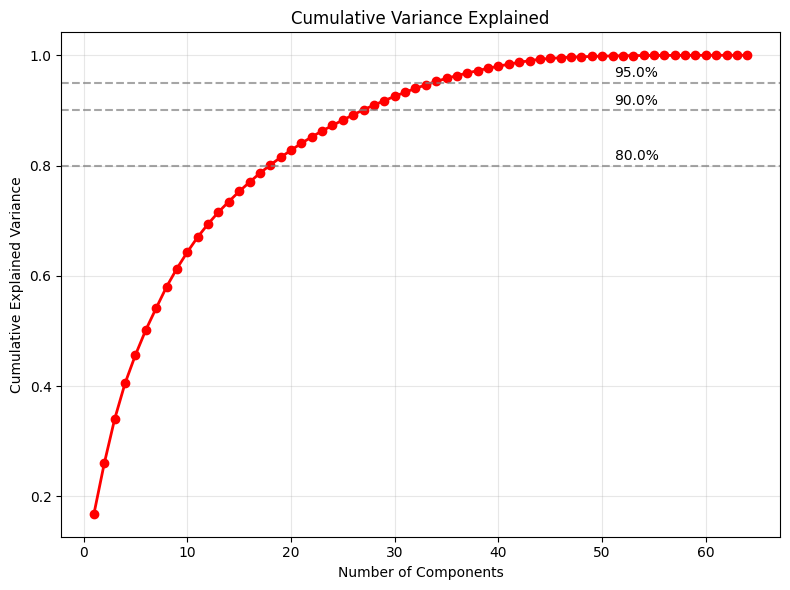

In [137]:
plot_pca_cumvar(pca_full)

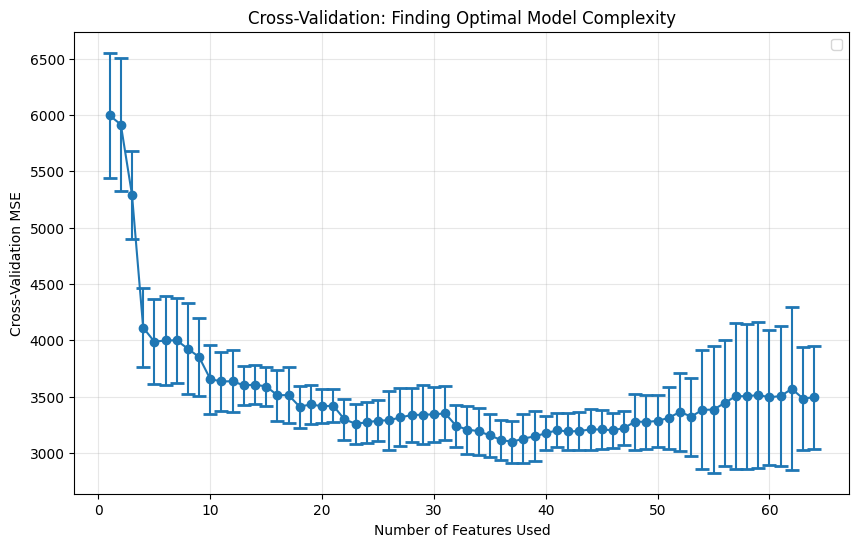

In [138]:
X_pca = pca_full.transform(X_scaled)

cross_validate_feature_range(X_pca, y, num_coef=None)

**Key Observations:**
- **Rapid variance capture**: The first 20 components explain over 95% of the total variance
- **Early performance plateau**: Cross-validation error stabilizes around 7-10 components
- **Diminishing returns**: Additional components beyond ~10 mainly capture noise rather than predictive signal

Next, we'll examine how the three regularization methods—Ridge, Lasso, and ElasticNet (λ = 0.5)—perform on this dataset.

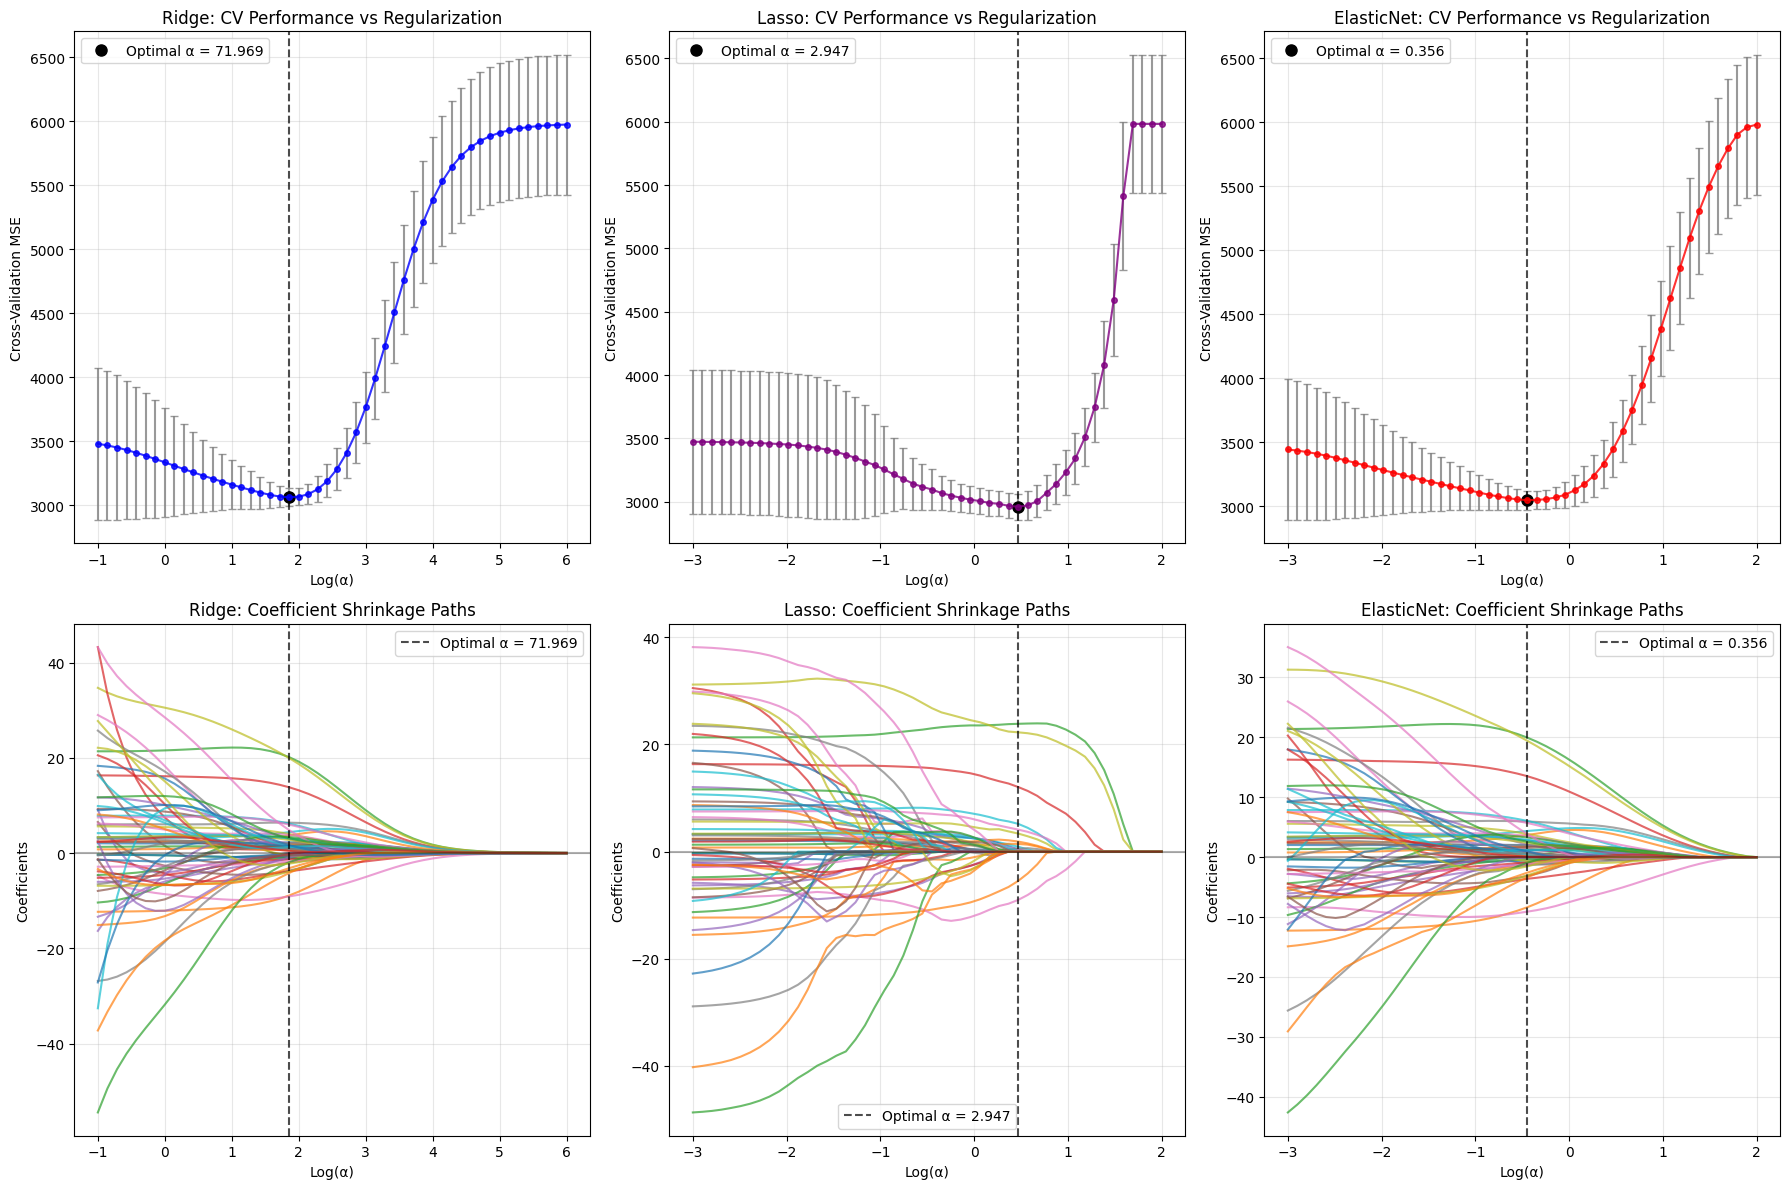

Regularization Methods Comparison:
Ridge:
  Optimal α: 71.9686
  Best CV MSE: 3062.92
  Features selected: 64/64

Lasso:
  Optimal α: 2.9471
  Best CV MSE: 2960.72
  Features selected: 15/64

ElasticNet:
  Optimal α: 0.3556
  Best CV MSE: 3046.99
  Features selected: 56/64



In [139]:
results = regularization_analysis(X_scaled, y)

**Regularization Methods Performance:**
- **Similar optimal performance**: All three methods achieve comparable cross-validation MSE (~3000-3500)
- **Different regularization strengths**: Optimal α values vary significantly across methods (Ridge: 71.969, Lasso: 2.947, ElasticNet: 0.356)

All methods perform reasonably well on this dataset. Let's investigate how the coefficients differ across all four approaches (including PCR)!

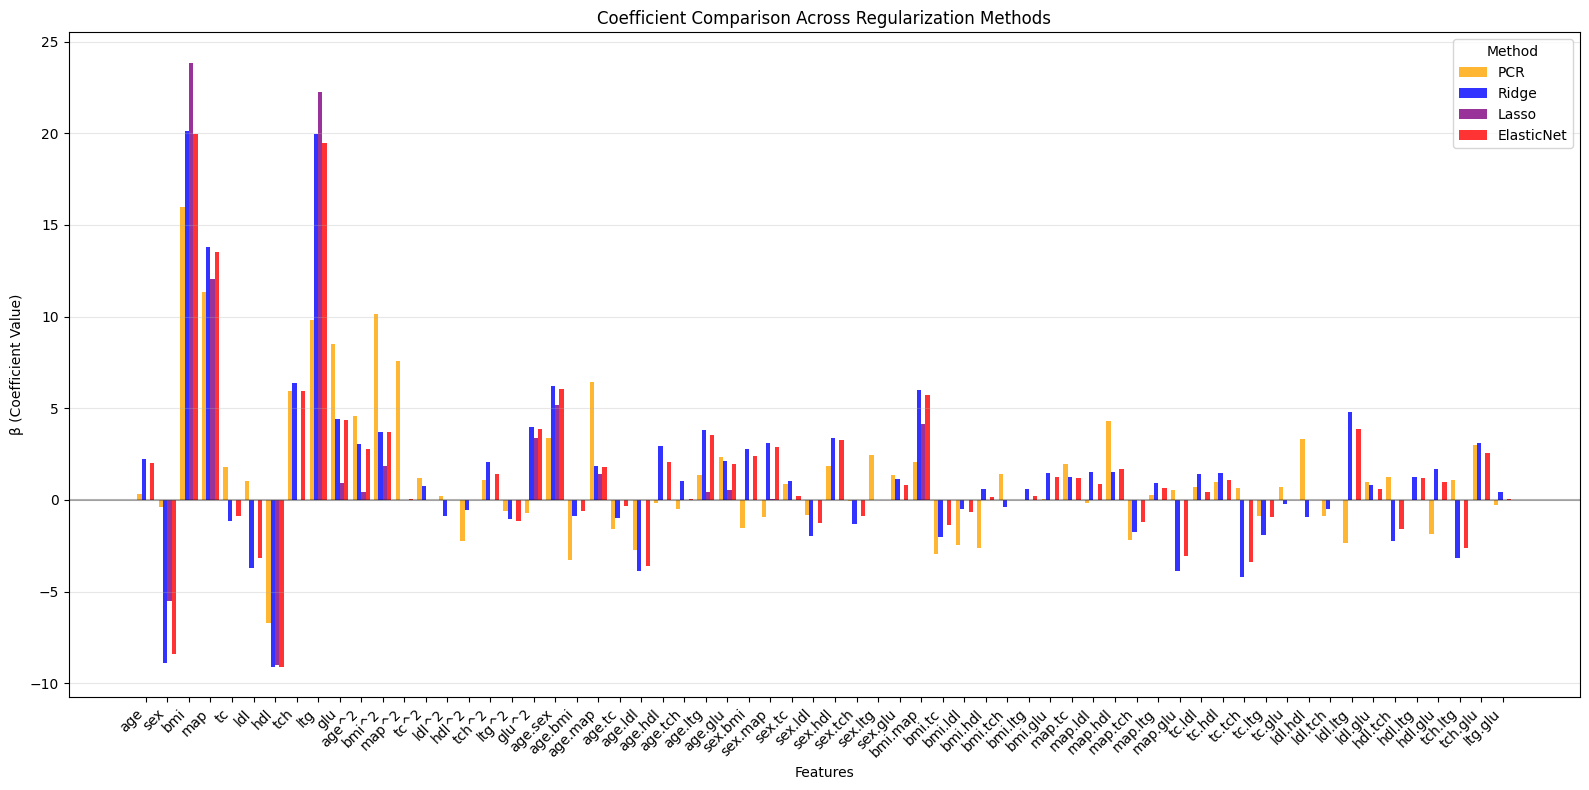

In [140]:
compare_coefficients_mult_methods(X_scaled, y, pca_n=20, reg_results=results, feature_names=X.columns)

- **Sparse vs. dense solutions**: Lasso eliminates many features entirely, while Ridge and PCR retain all with varying magnitudes
- **Feature agreement**: Key features like 'bmi' and 'bp' show consistent importance across methods, suggesting strong predictive signal
- **Method-specific selections**: Some features are only selected by certain methods, reflecting different regularization philosophies

**PCR Coefficient Transformation**: PCR works in the principal component space, not the original feature space. The regression coefficients are for the principal components, not the original features. To account for this we transformed the PC coefficients back to the original feature space:
```python
# PCR gives us: y = β₁·PC₁ + β₂·PC₂ + ... + βₖ·PCₖ
# But PC₁ = w₁₁·x₁ + w₁₂·x₂ + ... (linear combination of original features)
# So we compute: β_original = β_PC × W_components
pcr_coef_original = pcr_pipeline.named_steps['regression'].coef_ @ pca_components
```

The results demonstrate how different approaches handle the bias-variance tradeoff: PCR through dimensionality reduction, Ridge through uniform shrinkage, Lasso through feature selection, and ElasticNet through a balanced combination.

---